# 1. Data preparation for multi class classification

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [24]:
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 42

In [25]:
X, y = make_blobs(n_samples=1500, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

In [26]:
X[:5]

array([[ 5.09383203,  0.84175591],
       [ 2.74509933,  4.98234875],
       [-7.90501704,  5.61527324],
       [ 4.95245305, -1.08943262],
       [-6.01017743, -6.39141512]])

In [27]:
y[:10]

array([1, 4, 3, 1, 2, 1, 1, 3, 0, 2])

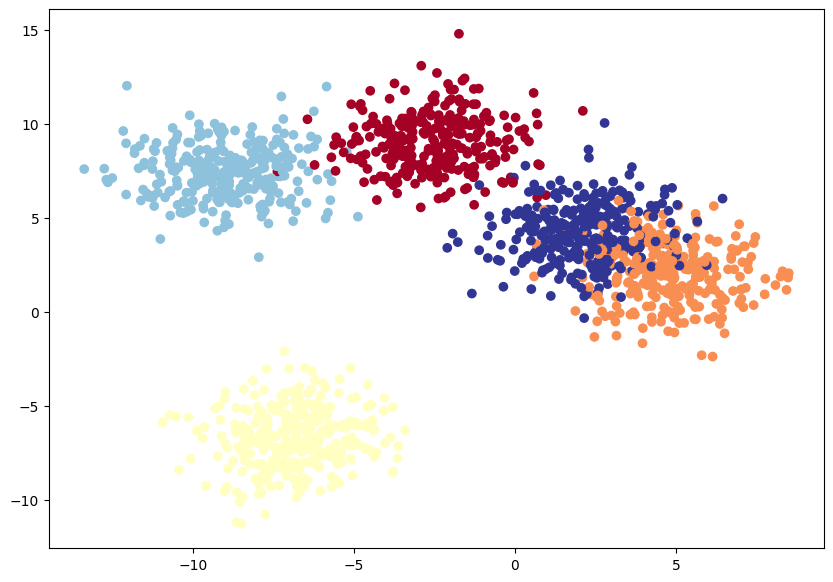

In [28]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [29]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [30]:
X[:5]

tensor([[ 5.0938,  0.8418],
        [ 2.7451,  4.9823],
        [-7.9050,  5.6153],
        [ 4.9525, -1.0894],
        [-6.0102, -6.3914]])

In [31]:
y[:10]

tensor([1, 4, 3, 1, 2, 1, 1, 3, 0, 2])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

In [33]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1050, 450, 1050, 450)

In [34]:
0.3 * len(X)

450.0

# 2. Building a model

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [36]:
from torch import nn

In [37]:
class MultiClassClassificationModel0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [38]:
model0 = MultiClassClassificationModel0(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)

print(model0)

MultiClassClassificationModel0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=5, bias=True)
  )
)


In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)

In [40]:
loss_fn

CrossEntropyLoss()

In [41]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [42]:
y_logits_untrained = model0(X_test.to(device))

In [43]:
y_logits_untrained

tensor([[ 0.3450,  1.0220, -0.2022,  0.1848, -0.9105],
        [-0.9557,  0.0870,  0.1281, -0.3851, -0.1196],
        [-0.6121,  0.1727, -0.0131, -0.1749, -0.2452],
        ...,
        [-0.6054, -0.4051, -0.2095,  0.0436,  0.0520],
        [-0.5175,  0.7239,  0.1244, -0.3122, -0.5525],
        [-0.6081, -0.0546, -0.0910, -0.0880, -0.1286]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [44]:
y_pred_probs = torch.softmax(y_logits_untrained)

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype = None, *, Tensor out = None)
 * (Tensor input, name dim, *, torch.dtype dtype = None)


torch.softmax(tensor, dim=X) applies the softmax along dimension X.

For each row (each sample),

→ take the logits across the class dimension (dim=1),

→ convert them into probabilities that sum to 1.

In [45]:
y_pred_probs = torch.softmax(y_logits_untrained, dim=1)

In [46]:
print(y_pred_probs)

tensor([[0.2135, 0.4202, 0.1235, 0.1819, 0.0608],
        [0.0920, 0.2610, 0.2720, 0.1628, 0.2123],
        [0.1249, 0.2739, 0.2274, 0.1935, 0.1803],
        ...,
        [0.1324, 0.1618, 0.1968, 0.2534, 0.2556],
        [0.1169, 0.4045, 0.2221, 0.1435, 0.1129],
        [0.1296, 0.2255, 0.2174, 0.2181, 0.2094]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [47]:
y_pred_probs[1]

tensor([0.0920, 0.2610, 0.2720, 0.1628, 0.2123], device='cuda:0',
       grad_fn=<SelectBackward0>)

index 4 has the highest probability value

In [48]:
torch.sum(y_pred_probs[1])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [49]:
torch.argmax(y_pred_probs[1])

tensor(2, device='cuda:0')

torch.argmax() will return the index of max value -> so model is predicting that for the inputs X_test[1], the output is 4

## 2.1 Training and testing loop

- Use raw logits with CrossEntropyLoss.
- Use raw logits with BCEWithLogitsLoss.

-> Don’t apply sigmoid() or softmax() before these losses — they already do it internally.

In [50]:
def accuracy_fn(y_true, y_preds):
    right = torch.eq(y_true, y_preds).sum().item() 
    acc = (right / len(y_preds)) * 100 
    return acc

In [51]:
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
RESET = "\033[0m"

In [52]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(epochs):
    model0.train()

    y_train_pred_logits = model0(X_train)
    y_train_preds = torch.softmax(y_train_pred_logits, dim=1).argmax(dim=1) # logits then get the probabilities then get the labels (index of max val in this case)

    train_loss = loss_fn(y_train_pred_logits, y_train)
    train_accuracy = accuracy_fn(y_train, y_train_preds)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    with torch.inference_mode():
        test_logits = model0(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, test_preds)


    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"\n{CYAN}{'='*65}{RESET}")
        print(f"{YELLOW}Epoch {epoch+1}/{epochs}{RESET}")
        print(f"{CYAN}{'-'*65}{RESET}")
        print(f"Train Loss     : {train_loss.item():.4f}")
        print(f"Train Accuracy : {train_accuracy:.2f}%")
        print(f"Test Loss      : {test_loss.item():.4f}")
        print(f"Test Accuracy  : {test_accuracy:.2f}%")
        print(f"{CYAN}{'='*65}{RESET}\n")


Epoch 10/100
-----------------------------------------------------------------
Train Loss     : 0.5142
Train Accuracy : 86.10%
Test Loss      : 0.4619
Test Accuracy  : 89.11%


Epoch 20/100
-----------------------------------------------------------------
Train Loss     : 0.3298
Train Accuracy : 91.52%
Test Loss      : 0.3029
Test Accuracy  : 91.78%


Epoch 30/100
-----------------------------------------------------------------
Train Loss     : 0.2637
Train Accuracy : 92.10%
Test Loss      : 0.2459
Test Accuracy  : 91.56%


Epoch 40/100
-----------------------------------------------------------------
Train Loss     : 0.2331
Train Accuracy : 92.48%
Test Loss      : 0.2196
Test Accuracy  : 91.56%


Epoch 50/100
-----------------------------------------------------------------
Train Loss     : 0.2171
Train Accuracy : 92.67%
Test Loss      : 0.2058
Test Accuracy  : 91.56%


Epoch 60/100
-----------------------------------------------------------------
Train Loss     : 0.2077
Train Accur

In [53]:
model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test)

In [54]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

In [55]:
y_preds[:10]

tensor([3, 4, 4, 3, 0, 4, 4, 3, 0, 4], device='cuda:0')

In [56]:
y_test[:10]

tensor([0, 4, 4, 3, 0, 4, 1, 3, 0, 1], device='cuda:0')

In [57]:
accuracy_fn(y_test, y_preds)

91.55555555555556

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, device="cpu", grid_steps=300, margin=0.5, title=None):
    """
    Plots a single decision boundary for a trained PyTorch model.

    Args:
        model: PyTorch model returning logits (binary or multi-class).
        X: torch.Tensor or np.ndarray, shape (N, 2)
        y: torch.Tensor or np.ndarray, shape (N,)
        device: 'cpu' or 'cuda'
        grid_steps: number of grid steps for mesh resolution
        margin: padding around data for plotting
        title: optional plot title (defaults to 'Decision boundary on provided data')
    """
    model.eval()
    model.to(device)

    # Ensure numpy
    X_np = X.detach().cpu().numpy() if isinstance(X, torch.Tensor) else np.asarray(X)
    y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

    assert X_np.shape[1] == 2, "Input X must be 2D for boundary plotting."

    # Create grid
    x_min, x_max = X_np[:, 0].min() - margin, X_np[:, 0].max() + margin
    y_min, y_max = X_np[:, 1].min() - margin, X_np[:, 1].max() + margin
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_steps),
        np.linspace(y_min, y_max, grid_steps)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Model predictions
    with torch.inference_mode():
        grid_t = torch.tensor(grid, dtype=torch.float32).to(device)
        logits = model(grid_t)

        if logits.ndim == 1 or logits.shape[1] == 1:  # Binary case
            probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)
            Z = (probs > 0.5).astype(int)
        else:  # Multi-class
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            Z = np.argmax(probs, axis=1).reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.6)
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=30, edgecolor="k")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title or "Decision boundary on provided data")
    plt.tight_layout()
    plt.show()

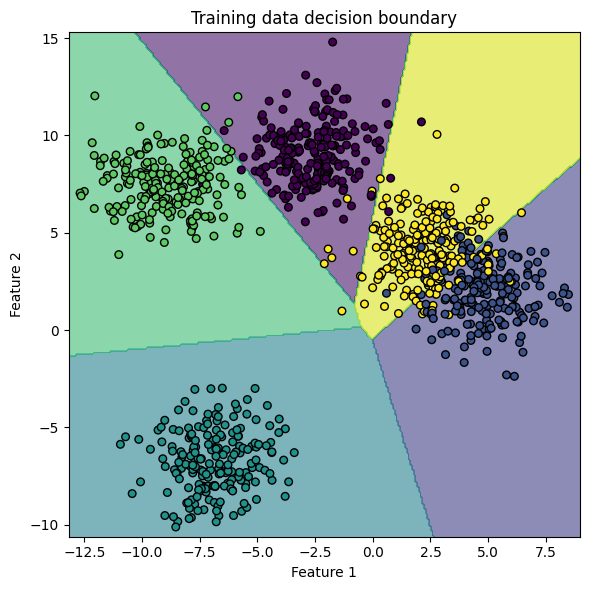

In [64]:
plot_decision_boundary(model0, X_train, y_train, title="Training data decision boundary")

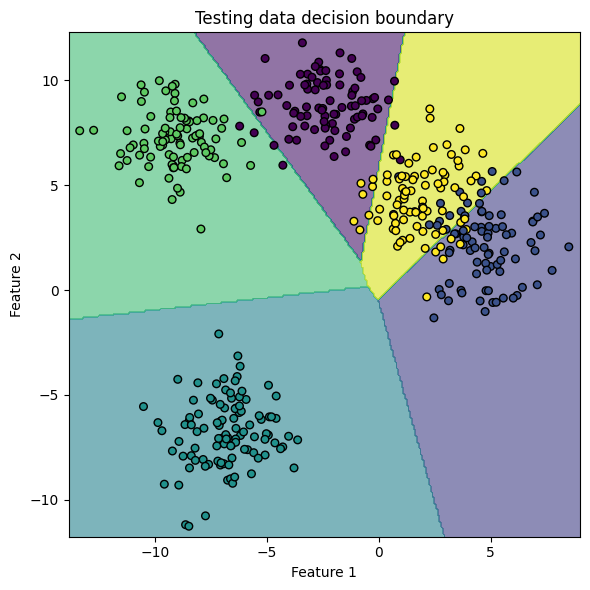

In [65]:
plot_decision_boundary(model0, X_test, y_test, title="Testing data decision boundary")

In [68]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=5).to(device)

torchmetrics_accuracy(y_preds, y_test)

tensor(0.9156, device='cuda:0')